In [200]:
from scipy.optimize import fsolve
import numpy as np
import matplotlib.pyplot as plt
import math

import tqdm

from itertools import combinations

In [201]:
def equation(x, t):
    eq = np.zeros(1)
    eq[0] = math.cos(x[0]) + math.cos(x[1]) - t[0]
    return eq


def equation2(x, t):
    eq = np.zeros(1)
    eq[0] = x[0] + x[1] - t[0]
    return eq

In [202]:
def equation_factory(x, x0, t, find_ids, equation):
    n = len(x) + len(x0)
    x_ = np.zeros(n)

    fixed_ids = []
    for i in range(n):
        if i not in find_ids:
            fixed_ids.append(i)

    x_[find_ids] = x
    x_[fixed_ids] = x0

    return equation(x_, t)


In [203]:
def carteisan_product(arrays):
    la = len(arrays)
    dtype = np.result_type(*arrays)
    arr = np.empty([len(a) for a in arrays] + [la], dtype=dtype)
    for i, a in enumerate(np.ix_(*arrays)):
        arr[...,i] = a
    return arr.reshape(-1, la)

In [204]:
xs = [np.linspace(-3.14, 3.14, 100), np.linspace(-3.14, 3.14, 100)]
x0s = [np.linspace(-3.14, 3.14, 5), np.linspace(-3.14, 3.14, 5)]

t = carteisan_product([np.linspace(-2, 2, 100)])


def GetCloud(xs, x0s, t, equation):

    n = len(xs)
    m = t.shape[1]
    r = n - m

    combs = list(combinations(range(n), r))

    slices = {}

    for t0 in tqdm.tqdm(t):

        slices[tuple(t0)] = []

        for c in combs:
            inx_solve = list(c)
            inx_fixed = list(set(range(n)) - set(c))

            x = carteisan_product([xs[i] for i in inx_fixed])
            x0 = carteisan_product([x0s[i] for i in inx_solve])

            for i in x:
                for j in x0:
                    y, infodict, ier, mesg = fsolve(equation_factory, j, args = (i, t0, inx_solve, equation), xtol = 1e-5, factor=0.1, maxfev=15, full_output=True)
                    if(ier == 1):
                        x_sol = np.zeros(n)
                        x_sol[inx_fixed] = i
                        x_sol[inx_solve] = y
                        slices[tuple(t0)].append(x_sol)
    return slices
        



slices = GetCloud(xs, x0s, t, equation2)

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:13<00:00,  7.40it/s]


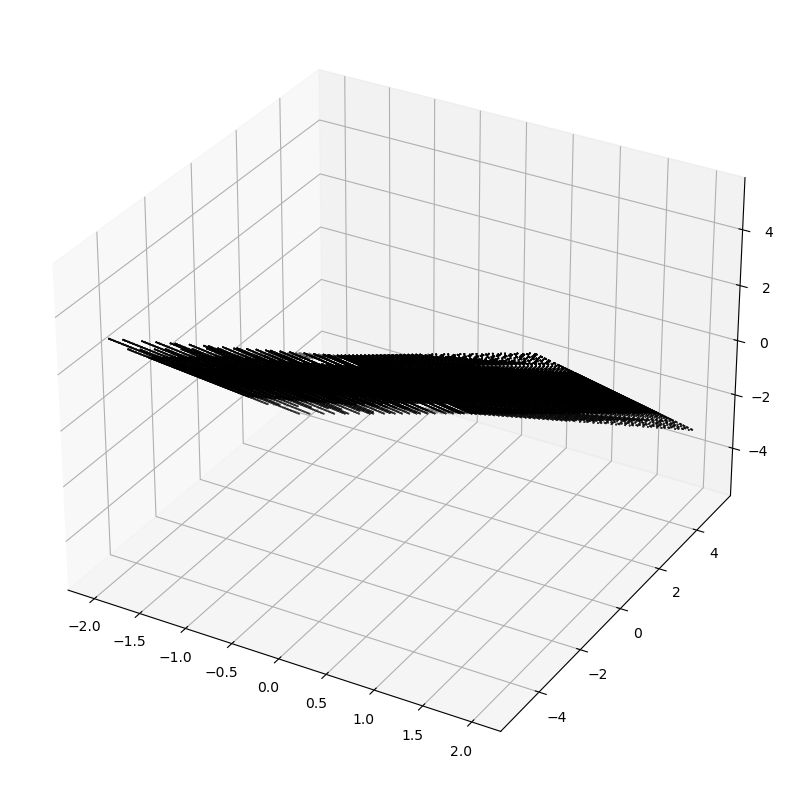

In [207]:
def Slices2Pointcloud(slices):

    pointcloud = np.zeros((0,3))

    for key in slices.keys():


        slice = np.array(slices[key])
        t = np.ones((slice.shape[0],1))*key

        if(len(slice) == 0):
            continue

        slice = np.concatenate((t, slice), axis=1)


        pointcloud = np.concatenate((pointcloud, slice), axis=0)


    return pointcloud


pointcloud = Slices2Pointcloud(slices)

# remove values larger than 10
pointcloud = pointcloud[pointcloud[:,1] < 10]
pointcloud = pointcloud[pointcloud[:,2] < 10]
# remove values smaller than -10
pointcloud = pointcloud[pointcloud[:,1] > -10]
pointcloud = pointcloud[pointcloud[:,2] > -10]


fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(pointcloud[:,0], pointcloud[:,1], pointcloud[:,2], s=0.1, c='k')

plt.show()
